Remember to download (one-time only) the CHIME package, https://github.com/chime-frb-open-data/chime-frb-open-data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

#for most recent data:
# import cfod
# from cfod import catalog
# data = catalog.as_dataframe()

## import data

In [2]:
CHIME = pd.read_csv("./data/chimefrb.csv") #catalog from 07/14
CHIME.head()

,tns_name,previous_name,repeater_name,snr_fitb,dm_fitb,dm_fitb_err,flux,flux_err,flux_notes,fluence,fluence_err,fluence_notes
0,FRB20180725A,180725.J0613+67,-9999,33.2,715.8090,0.0040,2.0,1.0,-9999,4.0,2.0,-9999
1,FRB20180727A,180727.J1311+26,-9999,12.2,642.1300,0.0200,0.6,0.3,-9999,2.3,0.8,-9999
2,FRB20180729A,180729.J1316+55,-9999,206.6,109.5942,0.0003,12.0,7.0,-9999,20.0,10.0,-9999
3,FRB20180729B,180729.J0558+56,-9999,22.0,317.2240,0.0040,0.9,0.6,-9999,1.2,0.7,-9999
4,FRB20180730A,180730.J0353+87,-9999,89.8,848.9040,0.0020,5.0,3.0,-9999,30.0,10.0,-9999


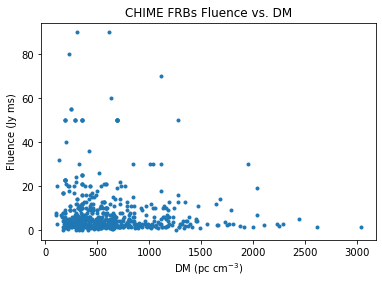

In [3]:
plt.scatter(CHIME['dm_fitb'], CHIME['fluence'], marker='.')
plt.xlabel('DM (pc cm$^{-3}$)')
plt.ylabel('Fluence (Jy ms)')
plt.title('CHIME FRBs Fluence vs. DM')
#plt.savefig('chimeFvDM.png', dpi=600)
plt.show()

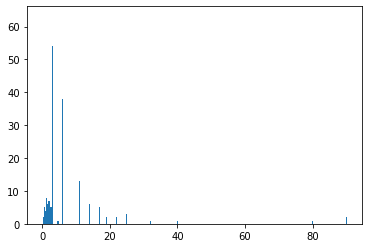

In [4]:
plt.hist(CHIME['fluence'], 1000)
plt.show()

## Cosmological Model Stuff

In [5]:
from petrosianfuncs.cosmology import *

In [6]:
import petrosianfuncs
help(petrosianfuncs.cosmology)

Help on module petrosianfuncs.cosmology in petrosianfuncs:

NAME
    petrosianfuncs.cosmology

FUNCTIONS
    DM(z, dDMdz=<function dDMdz_Arcus at 0x7f863d43c1f0>)
        (deprecated warning): input order is NOT same as output order
        ----------I/O-----------
        INPUT: 
        z     — single value or array/list of redshift
        dDMdz — dDM/dz model used, default Arcus
        
        OUTPUT: 
        DM(z) — DM(z), in pc cm^-3, single value or list depending on z input
        ------------------------
        
        Notes:
        all values of z must be >= 0
        dz = 0.001 by default, no parameter to change
    
    DM_single_z(z, dDMdz=<function dDMdz_Arcus at 0x7f863d43c1f0>)
        ----------I/O-----------
        INPUT: 
        z     — redshift (single value)
        dDMdz — dDM/dz model used, default Arcus
        
        OUTPUT: 
        DM(z), single value of DM at redshift=z
        ------------------------
        
        Notes:
        z must be >= 

In [7]:
#generate data values: might take a while

zs_model = np.linspace(0,10,2000)
DM_Arcus = DM(zs_model, dDMdz_Arcus)
DM_Zhang = DM(zs_model, dDMdz_Zhang)

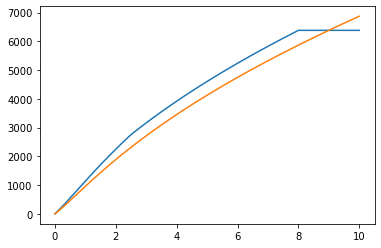

In [8]:
plt.plot(zs_model, DM_Arcus)
plt.plot(zs_model, DM_Zhang)

# Begin Analysis

In [9]:
#use those without fluence errors
#disregard fact that some are repeaters, for now.
Fs = np.array(CHIME[CHIME['fluence_notes'] == '-9999']['fluence'])
DMs = np.array(CHIME[CHIME['fluence_notes'] == '-9999']['dm_fitb'])

DMs, Fs = sort_by_first(DMs, Fs)
DMs, Fs = np.array(DMs), np.array(Fs)

In [10]:
zs = z_DM(DMs, DM_Arcus, zs_model)
Es = E_v(Fs, zs, alpha=1.5)
zcuts, Flim, alpha = np.linspace(0.1, 3, 200), 2.0, 1.5
Ecuts = E_v(np.full(len(zcuts), Flim), zcuts, alpha)

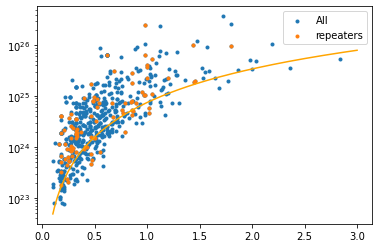

In [11]:
wfluence = CHIME[(CHIME['fluence_notes'] == '-9999')].reset_index()

plt.scatter(zs, Es, marker='.', label='All')
plt.plot(zcuts, Ecuts, color='orange')
plt.scatter(zs[wfluence['repeater_name'] != '-9999'], Es[wfluence['repeater_name'] != '-9999'], marker='.', label='repeaters')
plt.yscale('log')
plt.legend()
plt.show()

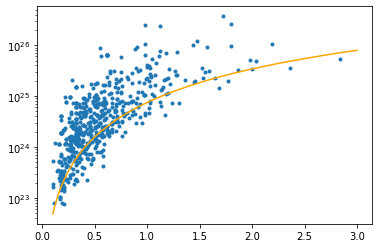

In [12]:
zcuts, Flim, alpha = np.linspace(0.1, 3, 200), 2.0, 1.5
Ecuts = E_v(np.full(len(zcuts), Flim), zcuts, alpha)
plt.scatter(zs, Es, marker='.', label='All')
plt.plot(zcuts, Ecuts, color='orange')
plt.yscale('log')

## kendall tau
- ADJUST PARAMETERS HERE! Flim, alpha

In [13]:
Flim = 2.0  #original 2.0
alpha = 1.5 #original 1.5

params = [alpha]

In [14]:
#clean up ones that are below the cutoff
#also exclude repeaters, for now
Elims = E_v(Flim, zs, *params)
Es_clean = Es[(Es > Elims) & (wfluence['repeater_name'] == '-9999')]
zs_clean = zs[(Es > Elims) & (wfluence['repeater_name'] == '-9999')]

#CLEAN DATA VARIABLES:
#Es_clean (energies)
#zs_clean (redshifts)

In [15]:
len(zs_clean)/len(zs)

0.6186440677966102

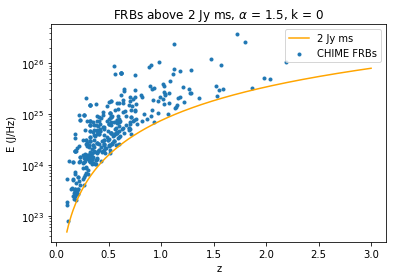

In [16]:
plt.scatter(zs_clean, Es_clean, marker='.', label='CHIME FRBs')
plt.plot(zcuts, Ecuts, color='orange', label='2 Jy ms')
plt.yscale('log')
plt.xlabel('z')
plt.ylabel('E (J/Hz)')
plt.title(f'FRBs above 2 Jy ms, $\\alpha$ = {alpha}, k = 0')
plt.legend()
#plt.savefig(f'../../FRBk={k_test}.png', dpi=600)
plt.show()

Text(0.5, 1.0, 'Best fit line when k=2: m=4.0')

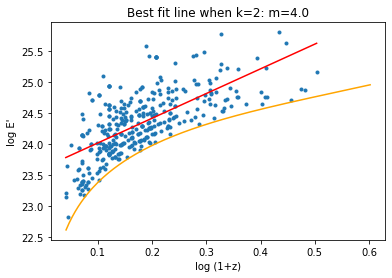

In [23]:
k_test = 2
Eprimes = Es_clean/g_new(zs_clean, k_test)
Ecutsprimes = Ecuts/g_new(zcuts, k_test)

plt.scatter(np.log10(zs_clean+1), np.log10(Eprimes), marker='.')
m, b = np.polyfit(np.log10(zs_clean+1), np.log10(Eprimes), 1)
plt.plot(np.log10(zs_clean+1), m*np.log10(zs_clean+1) + b, color='red')
plt.plot(np.log10(zcuts+1), np.log10(Ecutsprimes), color='orange')
plt.ylabel('log E\'')
plt.xlabel('log (1+z)')
plt.title(f'Best fit line when k={k_test}: m={round(m,2)}')
#plt.savefig('../../logE\'logz.png',dpi=600)

In [24]:
#df = ktau(Es_clean, zs_clean, 0, k=4, diag=True)
#df.to_csv('../../data_naive_k=4.csv')

In [25]:
m

3.999870136013929

In [20]:
Elim_clean = E_v(Flim, zs_clean, *params)

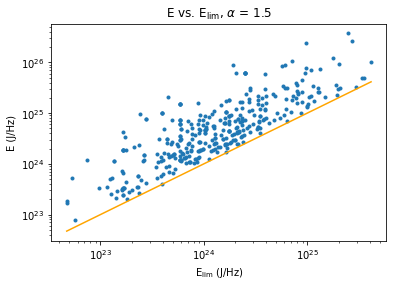

In [21]:
plt.scatter(Elim_clean, Es_clean, marker='.')
plt.plot([min(Elim_clean), max(Elim_clean)], [min(Elim_clean), max(Elim_clean)], color='orange')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('E (J/Hz)')
plt.xlabel('E$_{\\mathrm{lim}}$ (J/Hz)')
plt.title('E vs. E$_{\\mathrm{lim}}$, $\\alpha$ = 1.5')
#plt.savefig('EvElim_alph_1.5.png',dpi=600)
plt.show()

In [22]:
def g(z, k):
    return (1+z)**k

def g_new(z, k): #The improved g-function, which transforms luminosities
    Z = z+1
    Z_c = 3.5
    n = 3
    return Z**k/(1+(Z/Z_c)**n)**(k/n)


- should be fixed: ~note that the associated set requirement currently allows points under the cutoff to come in (as the jth point), even if points under the cutoff are not considered as the ith point~

In [26]:
def ktau(Es, z, Flim, func=E_v, g=g, k=0, params=[1.5], diag=False):
    
    R = []
    E = []
    V = []
    T = []
    
    gs = g(z,k)
    Elims_ = func(Flim, z, *params)
    
    for i in range(len(Es)):
        higher = 0
        lower = 0
        
        if Es[i] <= Elims_[i]: #skip points under cutoff
            continue
        
        for j in range(len(Es)): 
            
            if j == i or Es[j] <= Elims_[j]: #skip over itself or points under cutoff
                continue
                
            if(Es[j]/gs[j] >= Elims_[i]/gs[i] and z[j] <= z[i]): #associated set requirements
                
                if(Es[j]/gs[j] > Es[i]/gs[i]):
                    higher += 1
                else:
                    lower += 1
        
        N_i = higher+lower+1.
        R_i = (lower+1.)/N_i
        E_i = (1.+1./N_i)/2.
        V_i = (1.-1./N_i**2.)/12.
        
        if V_i == 0: #essentially, ignore points with only themselves in the associated set
            V_i += 1
        
        R.append(R_i) #diagnostic prints: print(f'loc: ({Es[i], z[i]}), high/low: {higher, lower}, rank: {R[len(R)-1]}'), print(f'loc: ({Es[i], z[i]}), {R_i}, {E_i}, {V_i}')
        E.append(E_i) #0.5
        V.append(V_i) #1/12
        T.append((R_i-E_i)/(V_i)**0.5)
    
    #numer = sum(R) - sum(E)
    #denom = (sum(V))**0.5
    if diag:
        df = pd.DataFrame()
        df['R'] = R
        df['E'] = E
        df['V'] = V
        return df
    return sum(T)/(len(T))**0.5

In [27]:
def ktau_E(Es, Elims, z, g=g, k=0):
    
    R = []
    E = []
    V = []
    T = []
    
    gs = g(z,k)
    
    for i in range(len(Es)):
        higher = 0
        lower = 0
        
        if Es[i] <= Elims[i]: #not considering data points under the cutoff
            continue
        
        for j in range(len(Es)): 
            if j == i or Es[j] <= Elims[j]: #skip over itself, data points under cutoff
                continue
                
            if(Es[j]/gs[j] >= Elims[i]/gs[i] and Elims[j] <= Elims[i]): #associated set requirements
                
                if(Es[j]/gs[j] > Es[i]/gs[i]):
                    higher += 1
                else:
                    lower += 1
        
        N_i = higher+lower+1.
        R_i = (lower+1.)/N_i
        E_i = (1.+1./N_i)/2.
        V_i = (1.-1./N_i**2)/12.
        
        if V_i == 0: #essentially, ignore points with only themselves in the associated set
            V_i += 1
        
        R.append(R_i) #diagnostic print: print(f'loc: ({Es[i], z[i]}), high/low: {higher, lower}, rank: {R[len(R)-1]}')
        E.append(E_i) #0.5
        V.append(V_i) #1/12
        T.append((R_i-E_i)/V_i**0.5)
    
    #numer = sum(R) - sum(E)
    #denom = (sum(V))**0.5
    return sum(T)/(len(T))**0.5

## applying kendall tau

In [28]:
ks = np.linspace(5, 15, 51)

taus = np.zeros(len(ks))
tau_Es = np.zeros(len(ks))

for i, k in enumerate(ks):
    taus[i] = ktau(Es_clean, zs_clean, Flim, g=g_new, k=k, params=params)
    tau_Es[i] = ktau_E(Es_clean, Elim_clean, zs_clean, g=g_new, k=k)

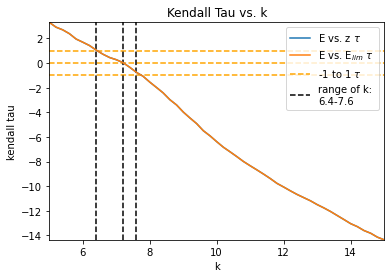

In [112]:
plt.plot(ks, taus, label='E vs. z $\\tau$')
plt.plot(ks, tau_Es, label='E vs. E$_{lim}$ $\\tau$')

plt.hlines([-1, 0, 1], min(ks), max(ks), color='orange', linestyle='--', label='-1 to 1 $\\tau$')

one = np.argwhere(np.diff(np.sign(taus-1))).flatten()
zer = np.argwhere(np.diff(np.sign(taus))).flatten()
neg = np.argwhere(np.diff(np.sign(taus+1))).flatten()


plt.vlines([ks[one], ks[zer], ks[neg]], min(taus), max(taus), color='black', label=f'range of k: \n{round(min(ks[one][0], ks[neg][0]), 2)}-{round(max(ks[one][0], ks[neg][0]),2)}', linestyle='--')

plt.xlim(min(ks), max(ks))
plt.ylim(min(taus), max(taus))

plt.xlabel('k')
plt.ylabel('kendall tau')
plt.title('Kendall Tau vs. k')
plt.legend()
#plt.savefig('ktau_edited.png', dpi=600)
plt.show()

In [113]:
ks[zer]

array([7.2])

# Debug

In [29]:
rng = np.random.default_rng(69)
xhist = rng.lognormal(mean=-1.0, sigma=1.0,size=1000000)+0.1

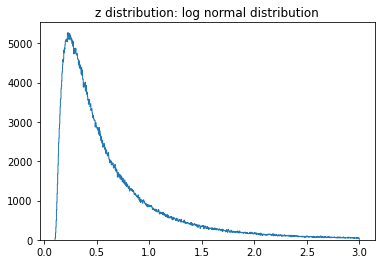

In [30]:
plt.hist(xhist[xhist<3], bins=1000, histtype='step')
plt.title('z distribution: log normal distribution')
#plt.savefig('../../lognormal.png', dpi=600)
plt.show()

Text(0.5, 0, 'z')

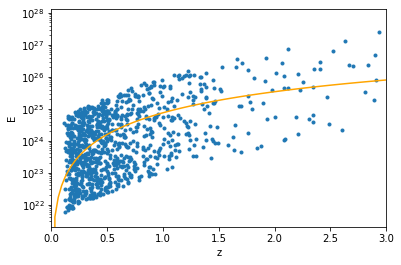

In [31]:
seed = 69
rng = np.random.default_rng(seed)
x = rng.lognormal(mean=-1.0, sigma=1.0,size=1000)+0.1
y = np.power(10,rng.random(1000)*3+23)*((1+x)/2)**(5)

zrand = np.linspace(0,3.0,100)

plt.scatter(x,y, marker='.')
plt.plot(zrand, E_v(2.0, zrand, alpha=1.5), color='orange')
plt.xlim([0,3.0])
plt.yscale('log')
plt.ylabel('E')
plt.xlabel('z')

In [32]:
Flim = 2.0
params = [1.5]
func = E_v
ylims = func(Flim, x, *params)
xcleans = x[np.logical_and(y > ylims, x<2.2)]
ycleans = y[np.logical_and(y > ylims, x<2.2)]
ylimcleans = ylims[y > ylims]
ktau(ycleans, xcleans, Flim, func=func, g=g, k=0, params=params)

7.138116187691706

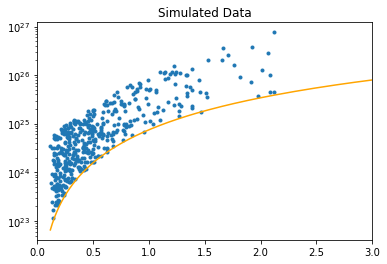

In [33]:
plt.scatter(xcleans, ycleans, marker='.')
plt.plot(sorted(x), sorted(ylims), color='orange')
plt.xlim([0,3])
plt.yscale("log")
plt.title('Simulated Data')
plt.savefig('../../simdata.png', dpi=600)

raw slope: 5.537095158648114 [naive] (best fit line for data above blue line)
true slope: 5.172712759169566 (best fit line for all data)


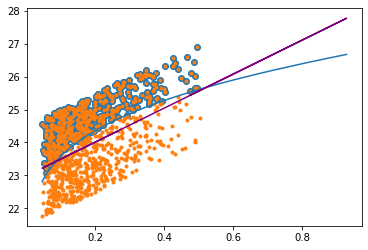

In [34]:
ylims = func(2.0, x, *[1.5])
plt.scatter(np.log10(1+xcleans), np.log10(ycleans))
plt.plot(sorted(np.log10(1+x)), sorted(np.log10(ylims)))
mraw, braw = np.polyfit(np.log10(1+xcleans), np.log10(ycleans), 1)
print('raw slope: ' + str(mraw) + ' [naive] (best fit line for data above blue line)')

plt.scatter(np.log10(1+x[x<2.2]),np.log10(y[x<2.2]), marker='.')
m,b=np.polyfit(np.log10(1+x[x<2.2]), np.log10(y[x<2.2]), 1)
print('true slope: ' + str(m) + ' (best fit line for all data)')
plt.plot(np.log10(1+x), np.log10(1+x)*m+b, color='purple', label='true fit')

In [35]:
def g_new(z, k, z_c=2.5, n=2):
    Z = 1.+z
    return Z**k/(1+(Z/z_c)**n)**(k/n)

def ktau_debug_graph(xcleans, ycleans, func):
    Flim = 2.0
    params = [1.5]
    
    ks = np.linspace(3,7,51)
    taus = np.zeros(len(ks))
    tau_ = np.zeros(len(ks))

    for i, k in enumerate(ks):
        taus[i] = ktau(ycleans, xcleans, Flim, func=func, g=g, k=k, params=params)
        tau_[i] = ktau(ycleans, xcleans, 0, func=func, g=g, k=k, params=params)
    
    plt.plot(ks, taus, label='w/ associated set')
    plt.plot(ks, tau_, label='naive')
    plt.hlines([-1, 0, 1], 3, 7)
    #plt.vlines([-1,0,1], min(taus), max(taus), color='black')
    plt.legend()
    plt.show()
    
    zer = np.argwhere(np.diff(np.sign(taus))).flatten()
    return ks[zer]

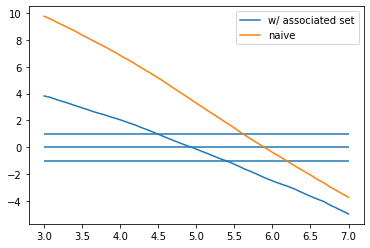

array([4.92])

In [36]:
ktau_debug_graph(xcleans,ycleans, func=func)

# next analysis, temporarily using k=3
## $\dot{\sigma}(z)$

In [37]:
def sigma_z(Es, z, Flim, func=E_v, g=g, k=0, params=[1.5]): #z0 being the z of interest
    
    gs = g(z,k)
    Elims_ = func(Flim, z, *params)
    
    zs_actual = []
    ms = []
    
    for i in range(len(Es)):
        m_i = 0

        if(Es[i] <= Elims_[i]): #not considering data points under the cutoff
            continue
        
        for j in range(len(Es)): 
            if i == j: #exclude itself
                continue
            if(Es[j]/gs[j] >= Elims_[i]/gs[i] and z[j] <= z[i]): #associated set requirements
                m_i += 1
                
        zs_actual.append(z[i])
        ms.append(m_i)
    
    #note that in sigma formula, 1+1/m[0] should be replaced with 1
    sigmas = [1]
    
    for i in range(1, len(zs_actual)):
        s_i = sigmas[i-1]*(1.+1./ms[i])
        sigmas.append(s_i)
    
    return np.array(sigmas), np.array(zs_actual)

def rawN(Es, z):
    z, Es = sort_by_first(z, Es)
    return np.arange(1, len(Es)+1), z

In [38]:
kval = 3 #temporary measure

sigma_noev, z_noev = sigma_z(Es_clean, zs_clean, 2.0, k=0)
sigma, z = sigma_z(Es_clean, zs_clean, 2.0, k=kval)
N, z_N = sigma_z(Es_clean, zs_clean, 2.0, func=(lambda a,b,c: np.zeros(len(b))))
N_test, z_test = rawN(Es_clean, zs_clean)

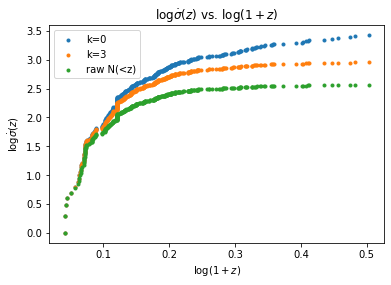

In [39]:
plt.scatter(np.log10(1+z_noev), np.log10(sigma_noev), marker='.', label='k=0')
plt.scatter(np.log10(1+z), np.log10(sigma), marker='.', label=f'k={kval}')
#plt.scatter(np.log10(1+z_N), np.log10(N), marker='.', color='black', label='raw N(<z)')
#note that the above version is actually slightly different from the actual raw N(<z), due ties in redshift
plt.scatter(np.log10(1+z_test), np.log10(N_test), marker='.', label='raw N(<z)')
plt.title('$\\log{\\dot{\\sigma}(z)}$ vs. $\\log{(1+z)}$')
plt.xlabel('$\\log{(1+z)}$')
plt.ylabel('$\\log{\\dot{\\sigma}(z)}$')
plt.legend()

## $\phi(E')$

In [40]:
z_Emodel = np.linspace(0, 3, 10000)
E_Emodel = E_v(2.0, z_Emodel, alpha=1.5)

In [41]:
def phi_E(Es, z, Flim, func=z_E, g=g, k=0, params=[1.5], model=[E_Emodel, z_Emodel]):
    #Note: we assume that Es, z are clean already (i.e. no points under the cutoff)
    
    gs = g(z,k)
    Emod, zmod = model
    Es_overg, z = sort_by_first(Es/gs, z)
    zmax = func(Es/gs, Emod/g(zmod, k), zmod)
    
    E_primes = []
    Es_raw = []
    ns = []
    
    for i in reversed(range(len(Es))):
        n_i = 0
        
        for j in range(len(Es)):
            if i == j: #skip over itself
                continue
                
            if (Es_overg[j] >= Es_overg[i] and z[j] <= zmax[i]): #associated set requirements
                n_i += 1
        
        ns.append(n_i)
        E_primes.append(Es_overg[i])
        Es_raw.append(Es_overg[i]*g(z[i],k))
        
        
    phis = [1]
    
    for i in range(1, len(E_primes)):
        phi_i = phis[i-1]*(1.+1./ns[i])
        phis.append(phi_i)
        
    return np.array(phis), np.array(E_primes), np.array(Es_raw)

In [42]:
phi_noev, E_noev, E_raw_0 = phi_E(Es_clean, zs_clean, 2.0, k=0)
phi, E_, E_raw_k           = phi_E(Es_clean, zs_clean, 2.0, k=kval)
N, E_N, E_raw_N           = phi_E(Es_clean, zs_clean, 2.0, func=(lambda a,b,c: np.ones(len(a))*np.inf))

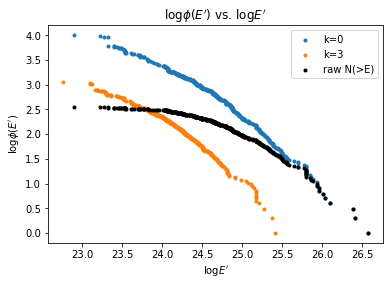

In [43]:
plt.scatter(np.log10(E_noev), np.log10(phi_noev), marker='.', label='k=0')
plt.scatter(np.log10(E_), np.log10(phi), marker='.', label=f'k={kval}')
plt.scatter(np.log10(E_N), np.log10(N), marker='.', color='black', label='raw N(>E)')
plt.title('$\\log{\phi(E\')}$ vs. $\\log{E\'}$')
plt.xlabel('$\\log E\'$')
plt.ylabel('$\\log \phi(E\')$')
plt.legend()
#plt.savefig('../../phi_E.png', dpi=600)

## formation rate evolution
$$\dot{\rho}(z) = (1+z) \frac{d\dot{\sigma}(z)/dz}{dV(z)/dz}$$

$$\dot{\sigma}(z) = \frac{Z^{d_1}}{\left(1 + (Z/Z_C)^{n(d_1-d_2)} \right)^{1/n}}$$

## decision
- choose a new function for $\dot{\sigma}$ at low $z$ such that its derivative $\to 0$ as $z \to 0$

In [44]:
def func_sigma(Z, d1, d2, Z_c, n):
    ratio = np.divide(Z, Z_c)
    return np.divide(np.power(Z, d1), np.power(1.0 + np.power(ratio, n*(d1-d2)), 1.0/n))

def logsigma(logZ, d1, d2, Z_c, n):
    return np.log10(func_sigma(np.power(10.0, logZ), d1, d2, Z_c, n))

import scipy.optimize as opt

In [45]:
guess = [5.8, 0.45, 1.66, 2.0]
bounds = [[0, 0, 0, 0], [100, 20, 20, 20]]
print('starting fitting')

#fit later points
ind=20
optsig, pcov = opt.curve_fit(logsigma, np.log10(1+z)[ind:], np.log10(sigma)[ind:], guess, bounds=bounds) 

print('done')

starting fitting
done


In [46]:
optsig

array([26.67876616,  0.48587286,  1.27231756,  0.3748458 ])

In [53]:
def plaw(z, C, p):
    return C*np.power(z,p)

def devPLaw(z, C, p):
    if p == 0:
        return z*0
    return C*p*np.power(z,p-1)

p = z[ind]*devSig(z[ind], *optsig)/sigma[20]
C = sigma[20]/(z[ind]**p)

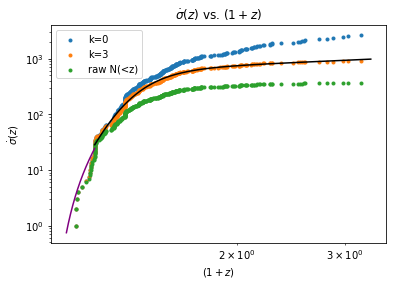

In [54]:
plt.scatter((1+z_noev), (sigma_noev), marker='.', label='k=0')
plt.scatter((1+z), (sigma), marker='.', label=f'k={kval}')
plt.scatter((1+z_test), (N_test), marker='.', label='raw N(<z)')


modelzs = np.linspace(z[ind], 2.3, 2000)
plt.plot(1+modelzs, func_sigma(1+modelzs, *optsig), color='black')

modelzs = np.linspace(0.06, z[ind], 500)
plt.plot(1+modelzs, plaw(modelzs, C, p), color='purple')

plt.title('${\\dot{\\sigma}(z)}$ vs. ${(1+z)}$')
plt.xlabel('${(1+z)}$')
plt.ylabel('${\\dot{\\sigma}(z)}$')
plt.yscale('log')
plt.xscale('log')
plt.legend()
#plt.savefig('../../sigma_z.png', dpi=600)

In [55]:
def devSig(z, d1, d2, Z_c, n):
    Z = z+1.0
    fac1 = np.power(Z, d1-1.0)
    fac2 = np.power(np.power(Z/Z_c, n*(d1-d2))+1.0, -1.0/n - 1.0)
    fac3 = d2*np.power(Z/Z_c, n*(d1-d2))+d1
    return fac1*fac2*fac3

def devSigGeneral(z, zcut, params1, params2):
    return np.piecewise(z, [z < zcut, z >= zcut], [lambda z:devPLaw(z, *params1), lambda z:devSig(z, *params2)])

In [56]:
def dVdz(z):
    '''
    in units of hubble volumes, D_H^3
    '''
    return 4*np.pi*(D_C(z))**2/(E(z))**0.5

def dotrho(z, optsig):
    return (1+z)*devSig(z, *optsig)/dVdz(z)

def dotrhoGeneral(z, zcut, params1, params2):
    return (1+z)*devSigGeneral(z, zcut, params1, params2)/dVdz(z)

In [57]:
zs = np.linspace(0, 5, 500)
rho = dotrho(zs, optsig)
rhoGen = dotrhoGeneral(zs, z[20], np.array([C,p]), optsig)

<ipython-input-56-96b403cbfaff>:8: RuntimeWarning: divide by zero encountered in true_divide
  return (1+z)*devSig(z, *optsig)/dVdz(z)
<ipython-input-56-96b403cbfaff>:11: RuntimeWarning: invalid value encountered in true_divide
  return (1+z)*devSigGeneral(z, zcut, params1, params2)/dVdz(z)


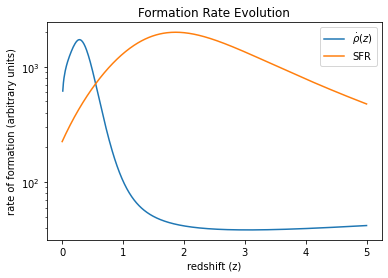

In [58]:
#plt.plot(zs, rho, label='rho')
plt.plot(zs, rhoGen, label='$\dot{\\rho}(z)$')
plt.plot(zs, SFR_Arcus(zs)*15000, label='SFR')
plt.yscale('log')
plt.ylabel('rate of formation (arbitrary units)')
plt.xlabel('redshift (z)')
plt.legend()
plt.title('Formation Rate Evolution')
#plt.savefig('../../FRE.png', dpi=600)
plt.show()

In [59]:
def SFR_Arcus(z):
    '''
    ----------I/O-----------
    INPUT: z — redshift (single value or numpy array)
    OUTPUT: SFR — (relative) star formation rate
    ------------------------
    
    Notes:
    SFR as defined by Arcus et al. 2020. SFR looks like a smooth peak at around z=2.
    '''
    
    Z=1+z
    return (0.015*(Z**2.7))/(1+(Z/2.9)**5.6)